In [137]:
import torch
import matplotlib.pyplot as plt

In [138]:
def data_points(data):
    """
    Wrapper for data points

    """
    def middle(func):
    
        def wrapper(*args, **kwargs):
            return func(data, *args, **kwargs)
        return wrapper
    
    return middle

In [139]:
def f(t, p_):
    return p_[0] * torch.exp(-t / p_[1]) + p_[2] * t * torch.exp(-t / p_[3])

In [140]:
class LevenbergMarquad:
        
    def condition1(self):
        """
        Add condition for Broyden 1-rank method convergence

        """
        pass

    def __init__(self, kwargs):
        self.JTWJ = None
        self.JTW = None
        self.dp = None
        self.y_data = kwargs.get('y') # 1-d tensor
        self.x_data = kwargs.get('x') # 1-d tensor
        self.func = kwargs.get('func')
        
        ###################################
        
        self.iter_n = 0
        self.p =  kwargs.get('init_p').detach().clone()
        self.p.requires_grad_(True)
        with torch.no_grad():
            self.J = torch.autograd.functional.jacobian(self.func, self.p)
        self.W = torch.diag(torch.tensor([1/kwargs.get('sigma')**2]*len(self.x_data))) # 1-d tensor
        self.lambda_lm = torch.tensor(kwargs.get('lambda_lm')) # float tensor
        
        ###################################
        
        self.eps1 = torch.tensor(kwargs.get('eps1')) # float tensor
        self.eps2 = torch.tensor(kwargs.get('eps2')) # float tensor
        self.eps3 = torch.tensor(kwargs.get('eps3')) # float tensor
        self.eps4 = torch.tensor(kwargs.get('eps4')) # float tensor
        self.lm_up = torch.tensor(kwargs.get('lm_up'))  # float tensor
        self.lm_down = torch.tensor(kwargs.get('lm_down'))  # float tensor
         
    @torch.no_grad()
    def broyden_jacobian_update(self):
        """
        Broyden 1-rank Jacobian update

        """
        df = self.func(self.p + self.dp) - self.func(self.p)
        self.J += torch.outer(df - torch.mv(self.J, self.dp),
                                self.dp) \
                         .div(torch.linalg.norm(self.dp, ord=2))
    @torch.no_grad()    
    def torch_jacobian_update(self, p_):
        """
        Finite-difference Jacobian update

        """
        self.J = torch.autograd.functional.jacobian(self.func, p_)
            
    @torch.no_grad()        
    def solve_for_dp(self):
        """
        Solver for optimizer step

        """
        self.JTW = torch.matmul(torch.transpose(self.J, 0, 1), self.W)
        self.JTWJ =  torch.matmul(self.JTW, self.J)
        
        dy =  self.y_data - self.func(self.p)
        self.dp = torch.linalg.solve(self.JTWJ 
                                     + self.lambda_lm * torch.diag(torch.diagonal(self.JTWJ)), 
                                    torch.mv(self.JTW , dy))
        
    @torch.no_grad()    
    def chi_2(self, p_):
        """

        chi2 = y^T.W.y + 2 * y^T.W . y_hat +  (y-hat)^T.W.y_hat

        """
        y_hat = self.func(p_)
        
        return torch.dot(self.y_data, torch.mv(self.W, self.y_data)) \
                - 2*torch.dot(self.y_data,
                              torch.mv(self.W, y_hat)) \
                + torch.dot(y_hat,
                            torch.mv(self.W,
                                     y_hat))
    
    @torch.no_grad()
    def rho(self):
        """
        rho =  chi2(p) - chi2(p + dp) / (dp)^T . ( lambda * diag(J^T W J).dp + J^T W . dy )

        """
        
        
        dy = self.y_data - self.func(self.p)  
        rho_ = ((self.chi_2(self.p) - self.chi_2(self.p + self.dp))
                .div(torch.dot(self.dp,  torch.mv(self.lambda_lm * torch.diag(torch.diagonal(self.JTWJ)), self.dp)
                                                                                 + torch.mv(self.JTW , dy)
                              ) 
                    )
                )
            
        
        if rho_ > self.eps4:
            return True
        else:
            return False
        
    @torch.no_grad()
    def update_p(self):
        self.p = self.p + self.dp
        
    def step(self):
        
        self.dp = 0
       
        self.solve_for_dp()
        
        if self.rho():
            self.update_p()
            self.lambda_lm = torch.maximum( self.lambda_lm / self.lm_down, torch.tensor(1e-7))
        else:
            self.lambda_lm = torch.minimum( self.lambda_lm * self.lm_up, torch.tensor(1e7))
            
        
        
        
        if self.iter_n % (2 * len(self.p)) == 0 :
            self.broyden_jacobian_update()
        else:
            
            self.p.requires_grad_(True)
            self.torch_jacobian_update(self.p)
            
        
        
        self.iter_n += 1
        
        
        return self.p


In [141]:
true_p = torch.tensor([20.0, 10.0, 1.0, 50.0]) # True parameters
x_true = torch.linspace(0, 100, 25) # span of of free parameter
y_true = f(x_true, true_p) # fitted function observed values
init_p = true_p + torch.randn(4)*2**2 + 4 # initial guess for parameters = true + noise
####
modified_f = data_points(x_true)(f) # wrapped function (dependent on only parameters)



In [142]:
print(f"Initial guess for optimizer {init_p}")

Initial guess for optimizer tensor([23.7923, 14.3195, -4.4983, 45.1029])


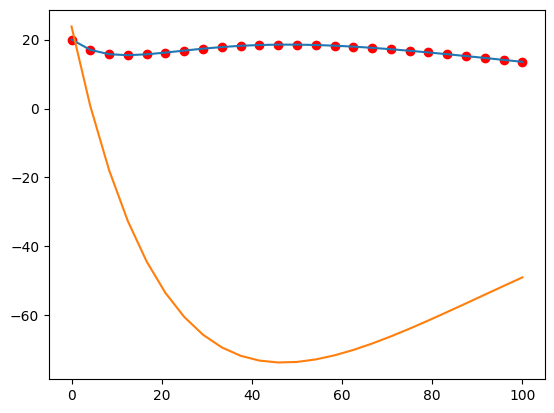

In [143]:
plt.scatter(x_true, y_true.numpy(), color='red')
plt.plot(x_true.numpy(), y_true.numpy())
plt.plot(x_true.numpy(), modified_f(init_p).numpy())
plt.show()

In [144]:
params = { 'x' : x_true,
           'init_p': init_p,
           'y' : y_true,
           'func' : modified_f,  # model to be fitted
           'sigma' : 4.0,    # std of datapoint
           'lambda_lm' : 10, # starting lambda
           'eps1' : 1e-3,    
           'eps2' : 1e-3,
           'eps3' : 1e-3,
           'eps4' : 1e-3,
           'lm_up' : 11,     # up coefficient
           'lm_down' : 9     # down coefficient
           }

In [145]:
lm = LevenbergMarquad(params)

In [146]:
p_hat = []
p = []
lmbd = []
for i in range(10):
    p.append(float(torch.linalg.norm(lm.step(), ord=2)))
    p_hat.append(float(torch.linalg.norm(lm.p - true_p , ord=2)))
    lmbd.append(lm.lambda_lm)

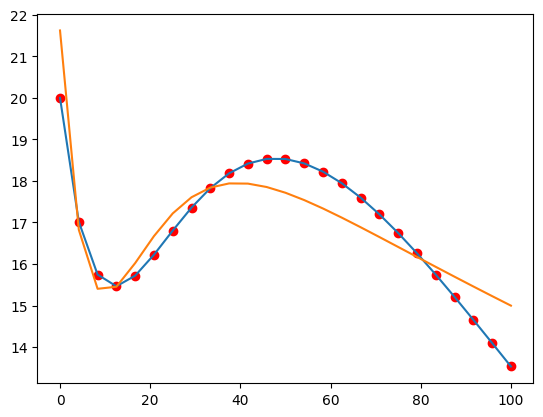

In [147]:
plt.scatter(x_true, y_true.numpy(), color='red')
plt.plot(x_true.numpy(), y_true.numpy())
#plt.plot(x_true.numpy(), modified_f(init_p).numpy())
plt.plot(x_true.numpy(), modified_f(lm.p).detach().numpy())
plt.show()

# SABR parameter estimation

$$
\begin{aligned}
\sigma_{B}(K, f)=& \frac{\alpha\left\{1+\left[\frac{(1-\beta)^{2}}{24} \frac{\alpha^{2}}{(f K)^{1-\beta}}+\frac{1}{4} \frac{\rho \beta v a}{(F K)^{(1-\beta) / 2}}+\frac{2-3 \rho^{2}}{24} v^{2}\right] T\right\}}{(f K)^{(1-\beta) / 2}\left[1+\frac{(1-\beta)^{2}}{24} \ln ^{2} \frac{f}{K}+\frac{(1-\beta)^{4}}{1920} \ln ^{4} \frac{f}{K}\right]}  \frac{z}{\chi(z)}\\
& \\
z=& \frac{v}{\alpha}(f K)^{(1-\beta) / 2} \ln \frac{f}{K} \\
\chi(z)=& \ln \left[\frac{\sqrt{1-2 \rho z+z^{2}}+z-\rho}{1-\rho}\right] .
\end{aligned}
$$

In [148]:
def sigma_SABR(k,
               p_,
               s=0.06,
               beta_ = 0.5,
               maturity=0.5):

    alpha_, nu_, rho_ = p_
    
    
   
    zeta = nu_ / alpha_ * (s * k) ** ((1.0 - beta_) / 2) * torch.log(s / k)
    
    numen = (1.0  + (((1 - beta_) ** 2 / 24) * alpha_ ** 2 / ((s * k) ** (1 - beta_))
                     + (rho_ * beta_ * nu_ * alpha_) / (4.0 * (s * k) ** ((1 - beta_) / 2))
                     + ((2 - 3 * rho_ ** 2) / 24 * nu_ ** 2)
                     ) * maturity
                   )
    
    
    denum =  ((s * k) ** ((1 - beta_) / 2) *
              (1.0 + (1 - beta_) ** 2 / 24 * torch.log(s / k) ** 2
               + (1 - beta_) ** 4 / 1920 * torch.log(s / k) ** 4
               )
              )
            
    
    anw = alpha_ * numen / denum * zeta / torch.log((torch.sqrt(1.0 - 2 * rho_ * zeta + zeta ** 2
                                                                ) + zeta - rho_) / (1.0 - rho_)
                                                    ) 
    
    return anw

In [149]:
K = torch.linspace(0.04, 0.11, 25)
S = 0.06
T = 0.5
alpha = 0.037561
beta = 0.5
rho = 0.100044
nu = 0.573296


In [150]:
init_p = torch.tensor([0.1]*3)
true_p = torch.tensor([ alpha, nu, rho])
y_mkt = sigma_SABR(K, true_p)

In [151]:
modified_sabr = data_points(K)(sigma_SABR)

In [152]:
params = { 'x' : K,
           'init_p': init_p ,
           'y' :  modified_sabr([ alpha, nu, rho]),
           'func' : modified_sabr,  # model to be fitted
           'sigma' : 1.0,    # std of datapoint
           'lambda_lm' : 0.01, # starting lambda
           'eps1' : 1e-3,    
           'eps2' : 1e-3,
           'eps3' : 1e-3,
           'eps4' : 1e-3,
           'lm_up' : 10,     # up coefficient
           'lm_down' : 9     # down coefficient
           }

In [153]:
lm = LevenbergMarquad(params)

In [154]:
for i in range(1000):
    lm.step()

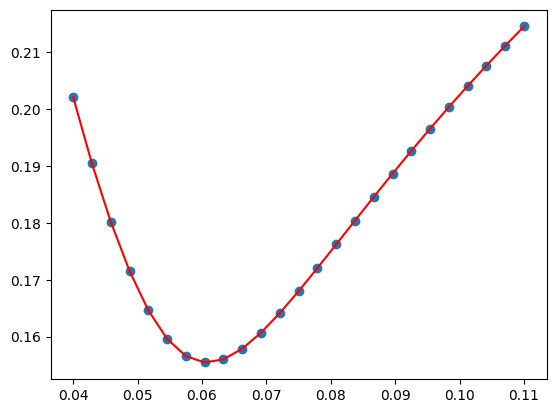

In [155]:
plt.scatter(K, modified_sabr([ alpha, nu, rho]))
plt.plot(K,  modified_sabr(lm.p).detach().numpy(), color='red')
plt.show()

In [156]:
print(f"Converged to {lm.p.detach()}", f"True p {true_p}", sep="\n")

Converged to tensor([0.0376, 0.5733, 0.1000])
True p tensor([0.0376, 0.5733, 0.1000])
